In [47]:
import pandas as pd
df = pd.read_csv('UTS_TT_DATA.csv')
print(df.head())

   row_number     affected_service priority  \
0       13133                Other    Minor   
1       17314  Intermittent signal    Minor   
2       17281       Loss of Signal    Minor   
3        3252  Intermittent signal   Medium   
4       10699       Loss of Signal    Minor   

                                         description  \
0  NTD ODU red. Rebooted in isolation, Still red....   
1  EU is reporting slow internet connection.\r\nP...   
2  ISSUE:  Red ODU\r\n\r\nService Address:|Addres...   
3  Fault Symptom: Drop Outs\r\n\r\nHave you check...   
4  EU is unable to connect to the internet.\r\nPr...   

                                               title    Fix Type  
0              NWAS-OTHER-*ANOM_ID36945*-ANOM_ID5775    TOW Used  
1      NWAS - Dropouts -*ANOM_ID42107*- ANOM_ID14570    TOW Used  
2                 NWAS -*ANOM_ID5433*-*ANOM_ID13853*  Remote Fix  
3  NWAS || Intermittent || ANOM_ID47835 || -*ANOM...    TOW Used  
4  NWAS||SERVICE LOSS||`ICE LOSS||-*ANOM_ID58

In [48]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords

In [49]:
stopwords = {}.fromkeys([ line.rstrip() for line in open('stopwords.txt')])
eng_stopwords = set(stopwords)

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in eng_stopwords]
    return ' '.join(words)

In [50]:
df['clean'] = df.description.apply(clean_text)

In [51]:
label_mapping = {'TOW Used':0,'Remote Fix':1}
df['label'] = df['Fix Type'].map(label_mapping)

In [52]:
df.head()

,row_number,affected_service,priority,description,title,Fix Type,clean,label
0,13133,Other,Minor,"NTD ODU red. Rebooted in isolation, Still red....",NWAS-OTHER-*ANOM_ID36945*-ANOM_ID5775,TOW Used,ntd odu red rebooted isolation red support tem...,0
1,17314,Intermittent signal,Minor,EU is reporting slow internet connection.\r\nP...,NWAS - Dropouts -*ANOM_ID42107*- ANOM_ID14570,TOW Used,eu reporting slow internet connection provisio...,0
2,17281,Loss of Signal,Minor,ISSUE: Red ODU\r\n\r\nService Address:|Addres...,NWAS -*ANOM_ID5433*-*ANOM_ID13853*,Remote Fix,issue red odu service address address removed ...,1
3,3252,Intermittent signal,Medium,Fault Symptom: Drop Outs\r\n\r\nHave you check...,NWAS || Intermittent || ANOM_ID47835 || -*ANOM...,TOW Used,fault symptom drop outs checked power cabling ...,0
4,10699,Loss of Signal,Minor,EU is unable to connect to the internet.\r\nPr...,NWAS||SERVICE LOSS||`ICE LOSS||-*ANOM_ID58216*...,TOW Used,eu unable connect internet provisioning nbn op...,0


In [53]:
# sentences = ['John likes ice cream', 'John hates chocolate.']
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer(min_df=0, lowercase=False)
# vectorizer.fit(sentences)
# print (vectorizer.vocabulary_)
# print (vectorizer.transform(sentences).toarray())

In [54]:
"""
split the dataset
"""
from sklearn.model_selection import train_test_split
sentences = df['clean'].values
y = df['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [55]:
"""
特征制作
"""
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
print (X_train.shape)
print (X_train[0].toarray())

(14963, 8240)
[[0 0 0 ... 0 0 0]]


In [56]:
"""
fundamental model"logistic regression"
"""
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.8309943865276664


D:\anaconda_files\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [61]:
"""
神经网络模型
""" 
from keras.models import Sequential
from keras import layers

# 稀疏矩阵转换
X_train = X_train.toarray()
X_test = X_test.toarray()

input_dim = X_train.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                82410     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 82,421
Trainable params: 82,421
Non-trainable params: 0
_________________________________________________________________
Train on 14963 samples, validate on 4988 samples
Epoch 1/100
14963/14963 [==============================] - 12s 805us/step - loss: 0.4355 - accuracy: 0.8365 - val_loss: 0.4156 - val_accuracy: 0.8396
Epoch 2/100
14963/14963 [==============================] - 11s 728us/step - loss: 0.4009 - accuracy: 0.8397 - val_loss: 0.4157 - val_accuracy: 0.8402
Epoch 3/100
14963/14963 [==============================] - 11s 738us/step - loss: 0.3847 - accuracy: 0.8423 - val_loss: 0.4089 - val_accuracy: 0.8392
Epoch 4/100


14963/14963 [==============================] - 5s 337us/step - loss: 0.2059 - accuracy: 0.9241 - val_loss: 1.1601 - val_accuracy: 0.8003
Epoch 52/100
14963/14963 [==============================] - 5s 325us/step - loss: 0.2034 - accuracy: 0.9260 - val_loss: 1.1825 - val_accuracy: 0.7721
Epoch 53/100
14963/14963 [==============================] - 5s 327us/step - loss: 0.2033 - accuracy: 0.9253 - val_loss: 1.1691 - val_accuracy: 0.7949
Epoch 54/100
14963/14963 [==============================] - 5s 329us/step - loss: 0.2017 - accuracy: 0.9258 - val_loss: 1.1893 - val_accuracy: 0.7919
Epoch 55/100
14963/14963 [==============================] - 5s 336us/step - loss: 0.2009 - accuracy: 0.9257 - val_loss: 1.2658 - val_accuracy: 0.8095
Epoch 56/100
14963/14963 [==============================] - 5s 338us/step - loss: 0.2016 - accuracy: 0.9260 - val_loss: 1.2419 - val_accuracy: 0.7933
Epoch 57/100
14963/14963 [==============================] - 5s 333us/step - loss: 0.1992 - accuracy: 0.9266 - val

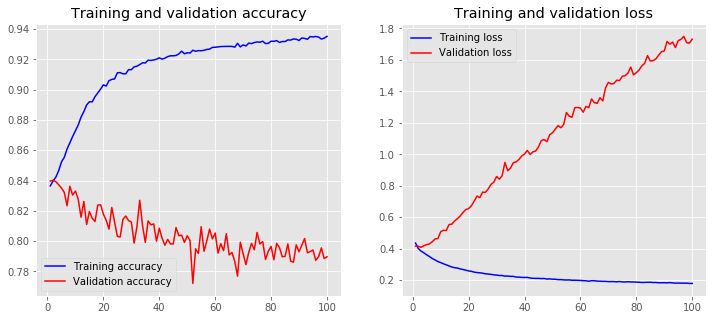

In [62]:
"""
结果展示
""" 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history,name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    #plt.show()
    plt.savefig(str(name)+'.png')
plot_history(history,name='base_nn')